```bash
conda create --name ani python=3.8
conda install -c conda-forge jupyterlab
pip install open_clip_torch
pip install stable-baselines3[extra]
pip install gym[all]
pip install pyglet==1.5.27
pip install tensorboardX
conda install -c anaconda ipywidgets
conda install -c anaconda scipy 
```

## Experiments
 - 2 environments: CartPole and LunarLander
 - clip models: openclip https://github.com/mlfoundations/open_clip(different models), cloob https://github.com/ml-jku/cloob
 - different prompts
     - try several prompts at the same time which describe different states and then the rwd is formulated based on to which prompt the env image is most similar
     - ...


In [1]:
import gym
from stable_baselines3 import DQN
import open_clip
from PIL import Image
import torch
import numpy as np
from tensorboardX import SummaryWriter
import os
import scipy.stats as stats
import json
import matplotlib.pyplot as plt

/home/dyari/anaconda3/envs/ani/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def disable_view_window():
        from gym.envs.classic_control import rendering
        org_constructor = rendering.Viewer.__init__

        def constructor(self, *args, **kwargs):
            org_constructor(self, *args, **kwargs)
            self.window.set_visible(visible=False)

        rendering.Viewer.__init__ = constructor

In [3]:
disable_view_window()

In [4]:
class CLIPEnv():
    def __init__(self, env, clip_model, clip_preprocess, tokenizer, prompt, writer):
        self.env = env
        self.model = clip_model
        self.preprocess = clip_preprocess
        self.tokenizer = tokenizer
        self.text_features = self.model.encode_text(self.tokenizer([prompt]))
        self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.metadata = self.env.metadata
        self.clip_rewards_per_episode = []
        self.env_rewards_per_episode = []
        
        self.clip_rewards = []
        self.env_rewards = []
        
        self.writer = writer
        self.n_steps = 0
        self.n_episodes = 0

    
    def reset(self):
        return self.env.reset()
    
    def close(self):
        return self.env.close()
    
    def step(self, action):
        next_st, rwd, done, info = self.env.step(action)
        img = self.env.render(mode="rgb_array")
        clip_rwd = self.get_clip_reward(img)
        
        self.clip_rewards_per_episode.append(clip_rwd)
        self.env_rewards_per_episode.append(rwd)
        
     
        if done:
            self.writer.add_scalar('episode_rewards/env_reward',  sum(self.env_rewards_per_episode), self.n_episodes)
            self.writer.add_scalar('episode_rewards/clip_reward', sum(self.clip_rewards_per_episode) , self.n_episodes)
            
            self.env_rewards.append(self.env_rewards_per_episode)
            self.clip_rewards.append(self.clip_rewards_per_episode)

            self.env_rewards_per_episode = []
            self.clip_rewards_per_episode = []
            
            self.n_episodes += 1
            
        
        self.n_steps += 1

        return next_st, rwd, done, info
    
    def get_clip_reward(self, state):
        image = self.preprocess(Image.fromarray(np.uint8(state))).unsqueeze(0)
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = self.model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            sim = (image_features @ self.text_features.T)
        return sim.cpu().detach().numpy()[0][0]

In [7]:
!mkdir experiments

mkdir: cannot create directory ‘experiments’: File exists


In [5]:
def run_exp(agent, env, prompt, clip_model_name, env_name, exp_path, n_steps, notes=''):
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)

    
    agent.learn(total_timesteps=n_steps, progress_bar=True)
    agent.save(f"{exp_path}/agent")
    
    corr = stats.pearsonr([sum(e) for e in env.env_rewards], [sum(e) for e in env.clip_rewards])[0]
    m_rwd = np.mean([sum(e) for e in env.env_rewards[-10:]])
    results = {
        'env_name': env_name,
        'prompt': prompt,
        'clip_model_name': clip_model_name,
        'correlation': corr,
        'mean_env_rwd_over_last_10_episodes': m_rwd,
        'n_episodes': env.n_episodes,
        'n_steps': env.n_steps,
         'notes': notes,
    }
    with open(f'{exp_path}/results.json', 'w') as f:
        json.dump(results, f)
    
    # compute correlation between env and clip rewards for each episode separately
    per_episode_corr = [stats.pearsonr(e, c)[0] for e, c in zip(env.env_rewards, env.clip_rewards)]
    for i in range(env.n_episodes):
        env.writer.add_scalar('Per episode correlation', per_episode_corr[i], i)

In [6]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')
tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')

In [ ]:
EXP_PATH = 'experiments/first_run/'
ENV_NAME = 'LunarLander-v2'
N_STEPS = 20000

env = gym.make(ENV_NAME)
prompt = 'Spaceship is on the landing pad'
writer = SummaryWriter(EXP_PATH)

cl_env = CLIPEnv(env, model, preprocess, tokenizer, prompt, writer)


agent = DQN('MlpPolicy', cl_env, verbose=0, learning_starts=1000, buffer_size=15000, target_update_interval=500)
run_exp(agent, cl_env, prompt, 'open_clip_ViT-B-32-quickgelu', ENV_NAME, EXP_PATH, N_STEPS,
        'all additional info about experiment goes here')

   2% ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390/20,000  [ 0:00:52 < 0:49:39 , 7 it/s ]

# Evaluate the trained agent

In [24]:
def experiment_prompt(prompt, agent, env, rewards_storage, n_steps=100):
    obs = env.reset()
    for _ in range(n_steps):
        action, _states = agent.predict(obs)
        obs, rewards, dones, info = env.step(action)
    rewards_storage[prompt] = (env.env_rewards.copy(), env.clip_rewards.copy())

In [25]:
prompt_rewards = {}

In [26]:
EXP_PATH = 'experiments/first_run/'
env = gym.make('LunarLander-v2')
cl_env = CLIPEnv(env, model, tokenizer, prompt, writer)
prompt = 'Spaceship is on the landing pad'

agent = DQN.load(f"{EXP_PATH}/agent", env=cl_env)
experiment_prompt(prompt, agent, cl_env, prompt_rewards)

In [18]:
cl_env.close()

Text(0.5, 1.0, 'Env rewards (1 episode)')

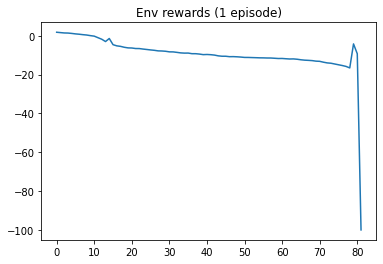

In [27]:
plt.plot(prompt_rewards['Spaceship is on the landing pad'][0][0])
plt.title('Env rewards (1 episode)')
plt.show()

Text(0.5, 1.0, 'CLIP rewards (1 episode)')

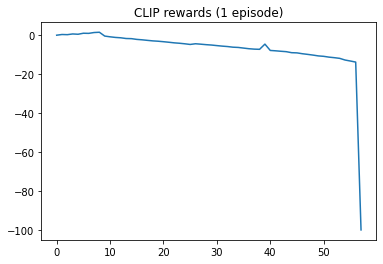

In [23]:
plt.plot(prompt_rewards['Spaceship is on the landing pad'][1][0])
plt.title('CLIP rewards (1 episode)')
plt.show()